In [1]:
%reload_ext autoreload
%autoreload 2

import os
import gc
import math
import time
import random
random.seed(42)

import numpy as np
import pandas as pd
from scipy.special import expit as sigmoid

import PIL

from tqdm import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

try:
    import efficientnet.tfkeras as efn
except:
    !python3 -m pip install --user efficientnet==1.1.0 attrdict
    print("please restart your jupyter kernel after running pip install")
    import efficientnet.tfkeras as efn

from attrdict import AttrDict
from one_cycle_scheduler import *

import random

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
num_workers = int(os.environ['SLURM_NNODES'])
node_id = int(os.environ['SLURM_NODEID'])

fold  = 0
kfold = 5
debug = True
batch_size = 80

In [3]:
CFG = AttrDict(
    batch_size       = batch_size,

    # Image sizes
    read_size        = 256, 
    crop_size        = 224, 
    net_size         = 224, 

    # Training Schedule
    LR_START         = 3e-3 * batch_size,
    LR_MAX           = 3e-2 * batch_size,
    LR_END           = 1e-2 * batch_size,
    LR_RAMPUP_EPOCHS = 0.5,
    epochs           = 6 if debug else 16,

    # Image Augmentation
    rot              = 180.0,
    shr              =   2.0,
    hzoom            =   8.0,
    wzoom            =   8.0,
    hshift           =   8.0,
    wshift           =   8.0,
    tta_steps        = 2 if debug else 4,

    optimizer        = tfa.optimizers.SGDW(lr=4e-2 * batch_size,
                                            nesterov=True,
                                            weight_decay=1e-5),
    label_smooth_fac = 0.05,
)

print(CFG)

AttrDict({'batch_size': 80, 'read_size': 256, 'crop_size': 224, 'net_size': 224, 'LR_START': 0.24, 'LR_MAX': 2.4, 'LR_END': 0.8, 'LR_RAMPUP_EPOCHS': 0.5, 'epochs': 6, 'rot': 180.0, 'shr': 2.0, 'hzoom': 8.0, 'wzoom': 8.0, 'hshift': 8.0, 'wshift': 8.0, 'tta_steps': 2, 'optimizer': <tensorflow_addons.optimizers.weight_decay_optimizers.SGDW object at 0x2aaaafd03ba8>, 'label_smooth_fac': 0.05})


In [4]:
BASEPATH   = "/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/"
OUTPUTPATH = os.environ['SCRATCH'] + f"/summer_school/melanoma_f{fold}/"
print(f"Training with {BASEPATH} and saving at {OUTPUTPATH}")

df_train = pd.read_csv(BASEPATH + 'train.csv')
df_test  = pd.read_csv(BASEPATH + 'test.csv')
df_sub   = pd.read_csv(BASEPATH + 'sample_submission.csv')

files_test  = np.sort(tf.io.gfile.glob(BASEPATH + 'test*.tfrec'))
files_train = np.sort(tf.io.gfile.glob(BASEPATH + 'train*.tfrec'))

idx = np.arange(len(files_train))
files_valid = files_train[idx % kfold == fold]
files_train = files_train[idx % kfold != fold]

print('Validation:\n', files_valid)
print('Training:\n',   files_train)

Training with /scratch/snx3000/dealmeih/summer_school/melanoma-256x256/ and saving at /scratch/snx3000/class211/summer_school/melanoma_f0/
Validation:
 ['/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train00-2182.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train05-2171.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train10-2174.tfrec']
Training:
 ['/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train01-2185.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train02-2193.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train03-2182.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train04-2167.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train06-2175.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train07-2174.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train08-2177.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/mela

In [5]:
# sample some data
pd.read_csv(BASEPATH + 'train.csv').sample(frac=1, random_state=4)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
3627,ISIC_1195689,IP_6885799,female,45.0,lower extremity,unknown,benign,0
30580,ISIC_9240657,IP_7772951,male,45.0,NaN,unknown,benign,0
56,ISIC_0097499,IP_0414408,male,50.0,lower extremity,unknown,benign,0
30652,ISIC_9263944,IP_2101945,male,65.0,lower extremity,unknown,benign,0
24244,ISIC_7358425,IP_9896679,female,35.0,torso,unknown,benign,0
...,...,...,...,...,...,...,...,...
23346,ISIC_7096946,IP_5805281,male,50.0,torso,nevus,benign,0
11863,ISIC_3653492,IP_8051701,female,65.0,upper extremity,unknown,benign,0
27063,ISIC_8198182,IP_9362467,female,45.0,torso,unknown,benign,0
8366,ISIC_2609984,IP_2586665,female,45.0,torso,melanoma,malignant,1


In [6]:
# Disable greedy GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# default strategy (single node + single GPU, if available)
strategy = tf.distribute.get_strategy()
replicas = strategy.num_replicas_in_sync

print(replicas, gpus)

1 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
%%writefile siic_tfrec_dataset.py
import os
import re

import numpy as np
import tensorflow as tf

from PIL import ImageFont
from PIL import ImageDraw

from augmentation import *

AUTO = tf.data.experimental.AUTOTUNE

def get_dataset(files, cfg, augment=False, shuffle=False, repeat=False, 
                labeled=True, return_image_names=True):
    ''' instantiate a TFRecord dataset '''
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)

    if repeat:
        ds = ds.repeat()

    if shuffle: 
        ds = ds.shuffle(1024*5)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      

    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, cfg=cfg), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)

    # use global batch size here
    ds = ds.batch(cfg['batch_size'])
    ds = ds.prefetch(AUTO)
    return ds


def read_labeled_tfrecord(example):
    ''' parse training data '''
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    ''' parse test data '''
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0


def prepare_image(img, cfg=None, augment=True):
    ''' decode and augment images '''
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    img = tf.cast(img, tf.float32) / 255.0

    if augment:
        img = transform(img, cfg)
        img = tf.image.random_crop(img, [cfg['crop_size'], cfg['crop_size'], 3])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
    else:
        img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])

    if cfg['crop_size'] != cfg['net_size']:
        img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])
    return img


def count_data_items(filenames):
    ''' count number of images in a set of TFRecords '''
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)


def show_dataset(thumb_size, cols, rows, ds):
    ''' create a grid of images from a TF dataset '''
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))

    targets = []
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        ImageDraw.Draw(img).text((4, 2), str(target_or_imgid.numpy()), (0,0,0))
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)

Overwriting siic_tfrec_dataset.py


In [8]:
from siic_tfrec_dataset import get_dataset, count_data_items, show_dataset

ds_train = get_dataset(files_train, CFG, augment=True, shuffle=True, repeat=True)
ds_valid = get_dataset(files_valid, CFG, augment=False, shuffle=False, repeat=True)

steps_train = count_data_items(files_train) // CFG.batch_size
steps_valid = count_data_items(files_valid) // CFG.batch_size
if debug:
    steps_train = 50

print(f'Training for {steps_train} steps and ' +
      f'validating for {steps_valid} steps per epoch, '
      f'across {num_workers} node(s)')

Training for 50 steps and validating for 81 steps per epoch,across 2 node(s)


## Test the input pipeline

In [9]:
# ds = get_dataset(files_train, CFG, shuffle=True).unbatch().take(12*3)   
# show_dataset(64, 12, 3, ds)
# del ds

## Test image augmentation

In [10]:
# ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
# ds = ds.take(1).repeat()
# ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
# ds = ds.map(lambda img, target: (prepare_image(img, cfg=CFG, augment=True), target), 
#             num_parallel_calls=AUTO)
# ds = ds.take(12*3)

# show_dataset(64, 12, 3, ds)
# del ds

## Images from the test data

In [11]:
# ds = get_dataset(files_test, CFG, labeled=False).unbatch().take(8*3)   
# show_dataset(96, 8, 3, ds)
# del ds

# Model

In [12]:
%%writefile deep_binary_classifier.py
import os
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

def get_model(cfg, backbone, drop_rate=0.3, **kwargs):
    ''' create typical transfer learning model with a given backbone '''
    model_input = tf.keras.Input(shape=(cfg['net_size'], cfg['net_size'], 3), name='in')
    outputs = []

    x = backbone(include_top=False,
                 input_shape=(cfg['net_size'], cfg['net_size'], 3),
                 **kwargs)(model_input)

    x = tf.keras.layers.Dropout(rate=drop_rate, name='top_dropout')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(model_input, x, name='EfficientNet')

    model.summary()
    return model

def compile_new_model(cfg,
                      backbone=efn.EfficientNetB0,
                      weights='noisy-student',
                      **kwargs):
    ''' create and compile a binary classifier '''
    model = get_model(cfg,
                      backbone=backbone,
                      weights=weights,
                      **kwargs)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=cfg['label_smooth_fac'])

    model.compile(
        optimizer = cfg['optimizer'],
        loss      = loss,
        metrics   = [tf.keras.metrics.AUC(name='auc')])

    return model

Overwriting deep_binary_classifier.py


In [13]:
from deep_binary_classifier import compile_new_model

with strategy.scope():
    model = compile_new_model(CFG,
                              efn.EfficientNetB2,
                              BASEPATH + '../efficientnet-b2_noisy-student_notop.h5',
                              pooling='avg',
                             )

# EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks
# https://arxiv.org/pdf/1905.11946.pdf

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b2 (Model)      (None, 1408)              7768562   
_________________________________________________________________
top_dropout (Dropout)        (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1409      
Total params: 7,769,971
Trainable params: 7,702,403
Non-trainable params: 67,568
_________________________________________________________________


In [14]:

# Log loss and metric history in TensorBoard format
tb_logdir = OUTPUTPATH + 'logs'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=tb_logdir, update_freq=steps_train//10,
                                                histogram_freq=0, profile_batch=0)

# In TF <=2.2 ModelCheckpoint allows fault tolerance
# in cases where workers die or are otherwise unstable.
# We do this by preserving training state in the distributed file system of your choice,
# such that upon restart of the instance that previously failed or preempted,
# the training state is recovered.
checkpoint_path = OUTPUTPATH + 'weights{epoch:03d}-auc{val_auc:.05f}.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    verbose=1, monitor='val_auc', mode='max',
)

# Stops training if metric dosen't improve for 'patience' epoches
stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=1e-5,
                                               mode='max', patience=CFG.epochs//2, verbose=1,
                                               restore_best_weights=True)

# LR and momentum scheduler
if 'LR_RAMPUP_EPOCHS' in CFG.keys():
    lr_sched_cb = OneCycleScheduler(lr_max=CFG.LR_MAX,
                                    steps=CFG.epochs * steps_train,
                                    mom_min=0.85, mom_max=0.95,
                                    phase_1_pct=CFG.LR_RAMPUP_EPOCHS / CFG.epochs,
                                    div_factor=CFG.LR_MAX / CFG.LR_START,
                                    final_div_factor=CFG.LR_MAX / CFG.LR_END)
else:
    lr_sched_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto', verbose=1,
                                                       factor=0.3, patience=2, cooldown=1,
                                                       min_delta=1e-4, min_lr=1e-8)

callbacks = [tensorboard_cb, checkpoint_cb, stopping_cb, lr_sched_cb]

In [15]:
!rm -rf {tb_logdir}

from tb_cscs import tensorboard
%tensorboard  --logdir={tb_logdir}  --host localhost

In [16]:
history = model.fit(ds_train, 
                    verbose          = 1,
                    steps_per_epoch  = steps_train,
                    epochs           = CFG.epochs,
                    validation_data  = ds_valid,
                    validation_steps = steps_valid,
                    callbacks        = callbacks
                   )

Epoch 1/6
50/50 [==============================] - ETA: 0s - loss: 0.2156 - auc: 0.5747
Epoch 00001: val_auc improved from -inf to 0.49223, saving model to /scratch/snx3000/class211/summer_school/melanoma_f0/weights001-auc0.49223.h5
50/50 [==============================] - 45s 907ms/step - loss: 0.2156 - auc: 0.5747 - val_loss: 0.2337 - val_auc: 0.4922
Epoch 2/6
50/50 [==============================] - ETA: 0s - loss: 0.1717 - auc: 0.6945
Epoch 00002: val_auc improved from 0.49223 to 0.64856, saving model to /scratch/snx3000/class211/summer_school/melanoma_f0/weights002-auc0.64856.h5
50/50 [==============================] - 44s 877ms/step - loss: 0.1717 - auc: 0.6945 - val_loss: 0.1791 - val_auc: 0.6486
Epoch 3/6
50/50 [==============================] - ETA: 0s - loss: 0.1665 - auc: 0.7221
Epoch 00003: val_auc improved from 0.64856 to 0.70024, saving model to /scratch/snx3000/class211/summer_school/melanoma_f0/weights003-auc0.70024.h5
50/50 [==============================] - 44s 878ms/

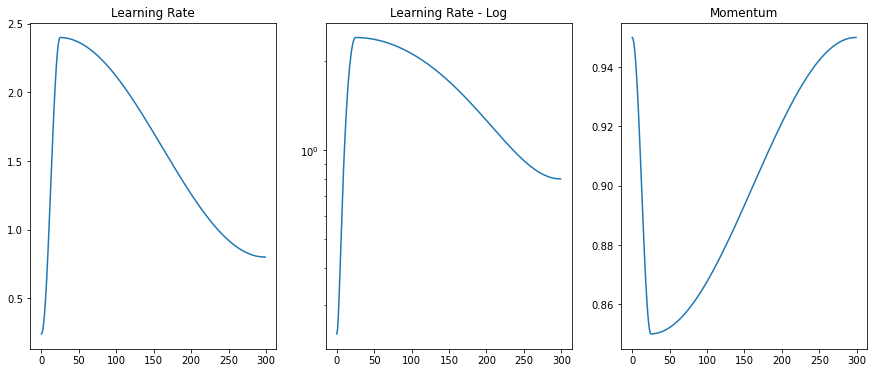

In [17]:
if hasattr(lr_sched_cb, 'plot'):
    lr_sched_cb.plot()

### predict the test set using augmented images

In [18]:
CFG['batch_size'] = 256

cnt_test   = count_data_items(files_test)
steps      = cnt_test / (CFG['batch_size']) * CFG['tta_steps']
ds_testAug = get_dataset(files_test, CFG, augment=True, repeat=True, 
                         labeled=False, return_image_names=False)

probs = model.predict(ds_testAug, verbose=1, steps=steps)
probs = probs[:cnt_test * CFG['tta_steps']].reshape(CFG['tta_steps'], cnt_test)
probs = np.mean(probs, axis=0)

86/85 [==============================] - 28s 328ms/step


### sort predictions to have the same order as the submission
The submission ist sorted by image_name, but the dataset yielded a different order.
Traverse the test dataset once again and capture the image_names. Then join this list of image_names with the predictions and sort by image_name.

In [19]:
ds = get_dataset(files_test, CFG, augment=False, repeat=False, 
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

,image_name,target
9905,ISIC_0052060,0.026045
1443,ISIC_0052349,0.027818
3120,ISIC_0058510,0.032658
4870,ISIC_0073313,0.029329
5494,ISIC_0073502,0.025767
...,...,...
5994,ISIC_9992485,0.031239
3980,ISIC_9996992,0.029012
6974,ISIC_9997917,0.047617
1278,ISIC_9998234,0.032751


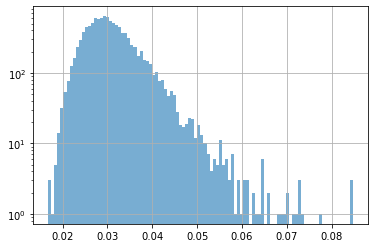

In [20]:
submission = pd.DataFrame(dict(
    image_name = image_names,
    target     = probs))

submission.target.hist(bins=100, log=True, alpha=0.6)

submission = submission.sort_values('image_name')
submission.to_csv('submission.csv', index=False)

submission

In [21]:
!ls -sh {OUTPUTPATH}

total 111M
4.0K logs		        27M weights003-auc0.70024.h5
 31M weights001-auc0.49223.h5   25M weights005-auc0.71068.h5
 31M weights002-auc0.64856.h5


In [22]:
df_sub = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))
assert len(submission) == len(df_sub)